In [1]:
# import os

# # 设置环境变量
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# # 打印环境变量以确认设置成功
# print(os.environ.get('HF_ENDPOINT'))

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import os
import json
import torch
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding, 
    Trainer, 
    TrainingArguments, 
    set_seed
)
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import classification_report


In [3]:
seed = 42
lang = "en"
# 设置随机种子
set_seed(seed)

result = {}
result["seed"] = seed
result["type"] = "no_finetune_baseline"

In [4]:
# 初始化模型和分词器
model_checkpoint = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

# 加载模型 (预训练权重 + 随机分类头)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
model.config.pad_token_id = model.config.eos_token_id

# 移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [5]:
# 定义两个专用的分词函数
def tokenize_short_function(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        max_length=256,      # short 子集：完全无截断
        padding="max_length"
    )

def tokenize_full_function(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True,
        max_length=512,      # full 子集：覆盖 ~97%，最佳平衡
        padding="max_length"
    )

def plot_and_save_confusion_matrix(preds, labels, dataset_name="Protein Short"):
    """
    绘制混淆矩阵，并打印分类报告
    """
    # 1. 计算准确率
    acc = accuracy_score(labels, preds)
    print(f"[{dataset_name}] Raw Accuracy: {acc:.4f}")
    
    # 2. 检查翻转
    is_flipped = False
    if acc < 0.5:
        print(f">>> Detected Label Inversion (Acc < 0.5). Rectifying...")
        preds = 1 - preds
        acc = accuracy_score(labels, preds)
        print(f"[{dataset_name}] Rectified Accuracy: {acc:.4f}")
        is_flipped = True
    
    # ================= [新增] 打印详细分类报告 =================
    print(f"\n>>> Classification Report for {dataset_name}:")
    # target_names 对应 0 和 1 的含义
    report = classification_report(labels, preds, target_names=['Non-Homologous', 'Homologous'], digits=4)
    print(report)
    print("="*40)
    # ========================================================

    # 3. 计算混淆矩阵
    cm = confusion_matrix(labels, preds)
    
    # 4. 绘图
    sns.set_theme(style="white", font_scale=1.2)
    plt.figure(figsize=(6, 5))
    
    class_names = ['Non-Homologous', 'Homologous']
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',
        cmap='Blues',
        cbar=False, 
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=1.5,
        linecolor='black',
        square=True
    )
    
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    
    plt.title(f'Confusion Matrix: Protein Homology Detection\nAccuracy: {acc:.2%}', 
              fontsize=14, pad=15, fontweight='bold')
    
    plt.tight_layout()
    
    filename = f"confusion_matrix_{dataset_name.replace(' ', '_')}_seed{seed}.png"
    plt.savefig(filename, dpi=300)
    print(f">>> Confusion Matrix saved to: {filename}")
    
    return acc

# 定义推理函数
def run_inference(test_dataset, batch_size=64):
    preds = []
    labels = []
    
    # disable=True 禁用进度条以保持输出纯净
    for i in tqdm(range(0, len(test_dataset), batch_size), desc="Predicting", disable=True):
        batch = test_dataset[i : i + batch_size]
        
        inputs = {
            "input_ids": torch.tensor(batch["input_ids"]).to(device),
            "attention_mask": torch.tensor(batch["attention_mask"]).to(device),
        }
        batch_labels = batch["label"] 

        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = torch.argmax(outputs.logits, axis=-1).cpu().numpy() 

        preds.extend(batch_preds)
        labels.extend(batch_labels)
        
    metric = evaluate.load("glue", "mrpc")
    plot_and_save_confusion_matrix(preds, labels)
    return metric.compute(predictions=preds, references=labels)

[Protein Short] Raw Accuracy: 0.6023

>>> Classification Report for Protein Short:
                precision    recall  f1-score   support

Non-Homologous     0.5583    0.9997    0.7165      3016
    Homologous     0.9983    0.2007    0.3343      2984

      accuracy                         0.6023      6000
     macro avg     0.7783    0.6002    0.5254      6000
  weighted avg     0.7772    0.6023    0.5264      6000

>>> Confusion Matrix saved to: confusion_matrix_Protein_Short_seed42.png


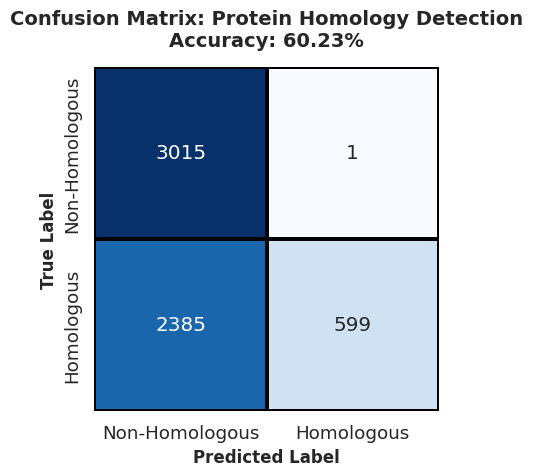

In [6]:
# ==========================================
# 测试集 1: protein_pair_short
# ==========================================
raw_datasets_short = load_dataset('dnagpt/biopaws', 'protein_pair_short')['train'].train_test_split(test_size=0.3, seed=seed)

# 直接分词
tokenized_raw_datasets_short = raw_datasets_short.map(tokenize_short_function, batched=True, num_proc=4)
ret_1 = run_inference(tokenized_raw_datasets_short["test"])
result["protein_pair_short"] = ret_1


Map (num_proc=4):   0%|          | 0/14000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6000 [00:00<?, ? examples/s]

[Protein Short] Raw Accuracy: 0.5638

>>> Classification Report for Protein Short:
                precision    recall  f1-score   support

Non-Homologous     0.5354    1.0000    0.6974      3016
    Homologous     1.0000    0.1230    0.2190      2984

      accuracy                         0.5638      6000
     macro avg     0.7677    0.5615    0.4582      6000
  weighted avg     0.7665    0.5638    0.4595      6000

>>> Confusion Matrix saved to: confusion_matrix_Protein_Short_seed42.png


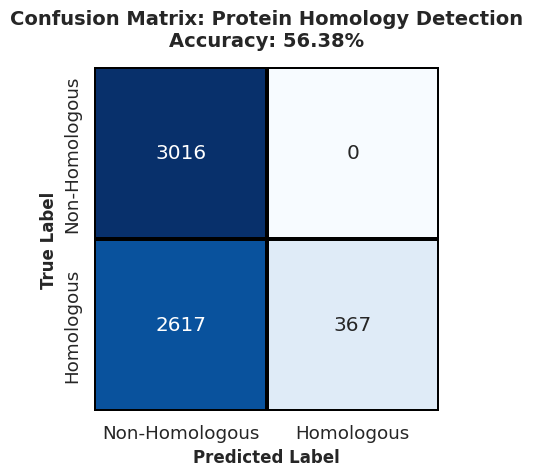

In [7]:
# ==========================================
# 测试集 2: protein_pair_full (
# ==========================================
raw_datasets_full = load_dataset('dnagpt/biopaws', 'protein_pair_full')['train'].train_test_split(test_size=0.3, seed=seed)

# 直接分词 (去除了 flip_labels 以保持与基线脚本一致)
tokenized_raw_datasets_full = raw_datasets_full.map(tokenize_full_function, batched=True, num_proc=4)
ret_2 = run_inference(tokenized_raw_datasets_full["test"])
result["protein_pair_full"] = ret_2

In [8]:
# ==========================================
# 输出结果
# ==========================================
print(json.dumps(result))

{"seed": 42, "type": "no_finetune_baseline", "protein_pair_short": {"accuracy": 0.6023333333333334, "f1": 0.33426339285714285}, "protein_pair_full": {"accuracy": 0.5638333333333333, "f1": 0.21903909280811698}}
